In [2]:
import numpy as np
import datetime
import matplotlib.pyplot as plt
from scipy.stats import norm, halfnorm, kstest, ks_2samp, wilcoxon, mannwhitneyu, probplot, expon
from scipy.optimize import curve_fit
import pickle
from statsmodels.graphics.gofplots import qqplot_2samples
import operator

In [3]:
mars = np.genfromtxt('data/harp_mars.dat', usecols=np.arange(0, 9))
jupiter = np.genfromtxt('data/harp_jupiter.dat', usecols=np.arange(0, 8))
uranus = np.genfromtxt('data/harp_uranus.dat', usecols=np.arange(0, 8))

In [4]:
mars_unc = np.genfromtxt('data/harp_mars_unc.dat')
jupiter_unc = np.genfromtxt('data/harp_jupiter_unc.dat')
uranus_unc = np.genfromtxt('data/harp_uranus_unc.dat')
planets_unc = np.concatenate((mars_unc[:,9], jupiter_unc[:,8], uranus_unc[:,8]), axis=0)

In [5]:
yerr = np.mean(planets_unc[planets_unc!=0])
print(yerr)

0.102780674017


In [6]:
mars_etamb = mars[:,5]
jupiter_etamb = jupiter[:,5]
uranus_etamb = uranus[:,5]

mars_dates = mars[:,0]
jupiter_dates = jupiter[:,0]
uranus_dates = uranus[:,0]

mars = mars[mars[:,1] > 5]
mars = mars[mars[:,1] < 19]
mars = mars[mars[:,5] > 0]
jupiter = jupiter[jupiter[:,1] > 5]
jupiter = jupiter[jupiter[:,1] < 19]
jupiter = jupiter[jupiter[:,5] > 0]
uranus = uranus[uranus[:,1] > 5]
uranus = uranus[uranus[:,1] < 19]
uranus = uranus[uranus[:,5] > 0]

planets_etamb = np.concatenate((mars_etamb, jupiter_etamb, uranus_etamb), axis=0)
raw_dates = np.concatenate((mars_dates, jupiter_dates, uranus_dates), axis=0)
dates = [datetime.datetime.strptime(str(int(date)),'%Y%m%d') for date in raw_dates]

In [7]:
oldest = min(dates)
days = np.array([np.float64((date - oldest).days) + 1 for date in dates])

In [8]:
def draw_samp(x, m, b, yerr_mu, yerr_sig, bias_mu, bias_sig, rel):
    result = []
    yerr = np.random.normal(yerr_mu, yerr_sig, size = len(x))
#     scatter = np.random.normal(scatter_mu, scatter_sig, size = len(x))
    bias = expon.rvs(bias_mu, bias_sig, size = len(x))
    result = yerr - rel*bias + (m*x + b)
    return np.array(result)

In [70]:
def draw_samp_yerrfix(x, m, b, yerr, bias_mu, bias_sig, rel):
    result = []
    bias = expon.rvs(bias_mu, bias_sig, size = len(x))
    result = yerr - rel*bias + (m*x + b)
    return np.array(result)

In [71]:
def draw_samp_yerrfix_halfnorm(x, m, b, yerr, bias_mu, bias_sig, rel):
    result = []
    bias = halfnorm.rvs(bias_mu, bias_sig, size = len(x))
    result = yerr - rel*bias + (m*x + b)
    return np.array(result)

In [93]:
sample_coarse = draw_samp_yerrfix(days, 0.0, .57, yerr, 0.0, .35, .45)

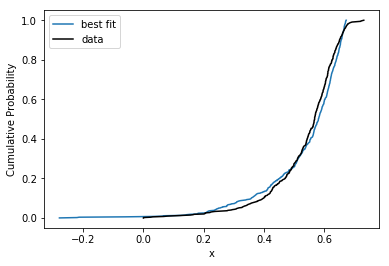

In [115]:
sort_y = np.sort(planets_etamb)
p = np.linspace(0, 1, len(planets_etamb))
data_CDF = lambda x: np.interp(x, sort_y, p)

#plotting CDF of data vs CDF of sample dataset
plt.figure()
plt.plot(np.sort(sample_coarse), p, label='best fit')
plt.plot(sort_y, p, label='data', color='k')
plt.xlabel('x')
plt.ylabel('Cumulative Probability')
plt.legend(loc='upper left')
plt.show()

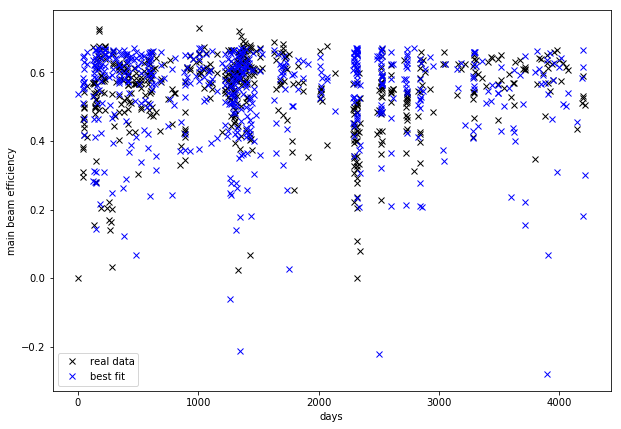

In [141]:
plt.figure(figsize=(10,7))
plt.plot(days, planets_etamb, 'kx', label='real data')
plt.plot(days, sample_coarse, 'bx',label='best fit')
plt.xlabel('days')
plt.ylabel('main beam efficiency')
plt.legend(loc='lower left')
plt.show()

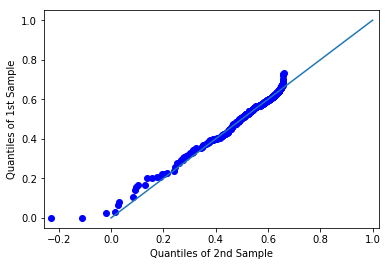

In [57]:
#qq plot for real data and "optimal param" data
plt.figure(1)
qqplot_2samples(planets_etamb, sample2)
plt.plot(np.linspace(0.0,1.0),np.linspace(0.0,1.0))
plt.show()

In [14]:
def calc1000tests(m, b, yerr_mu, yerr_sig, bias_mu, bias_sig, rel):
    ks_stats = [] #each has 1000 test stats, corresponding to one set of params
    mwu_stats = []
    wilcoxon_stats = []
    ks_pv = [] #each has 1000 p-values, corresponding to one set of params
    mwu_pv = []
    wilcoxon_pv = []
    samples = []
    for i in range(1000):
        trial = draw_samp(days, m, b, yerr_mu, yerr_sig, bias_mu, bias_sig, rel)
        samples.append(trial)
        stat = ks_2samp(planets_etamb, trial)
        ks_stats.append(stat[0])
        ks_pv.append(stat[1])
        stat = mannwhitneyu(planets_etamb, trial, alternative = 'two-sided')
        mwu_stats.append(stat[0])
        mwu_pv.append(stat[1])
        stat = wilcoxon(planets_etamb, trial)
        wilcoxon_stats.append(stat[0])
        wilcoxon_pv.append(stat[1])
        
    return samples, ks_stats, mwu_stats, wilcoxon_stats, ks_pv, mwu_pv, wilcoxon_pv

In [15]:
def calc1000tests_yerrfix(m, b, yerr, bias_mu, bias_sig, rel):
    ks_stats = [] #each has 1000 test stats, corresponding to one set of params
    mwu_stats = []
    wilcoxon_stats = []
    ks_pv = [] #each has 1000 p-values, corresponding to one set of params
    mwu_pv = []
    wilcoxon_pv = []
    samples = []
    for i in range(1000):
        trial = draw_samp_yerrfix(days, m, b, yerr, bias_mu, bias_sig, rel)
        samples.append(trial)
        stat = ks_2samp(planets_etamb, trial)
        ks_stats.append(stat[0])
        ks_pv.append(stat[1])
        stat = mannwhitneyu(planets_etamb, trial, alternative = 'two-sided')
        mwu_stats.append(stat[0])
        mwu_pv.append(stat[1])
        stat = wilcoxon(planets_etamb, trial)
        wilcoxon_stats.append(stat[0])
        wilcoxon_pv.append(stat[1])
        
    return samples, ks_stats, mwu_stats, wilcoxon_stats, ks_pv, mwu_pv, wilcoxon_pv

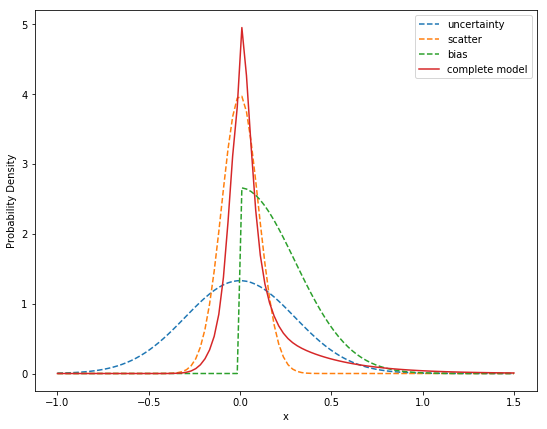

In [134]:
fig = plt.figure(figsize=(9, 7))
x = np.linspace(-1.0, 1.5, 100)
plt.xlabel('x')
plt.ylabel('Probability Density')
plt.plot(x, norm.pdf(x, 0.0, .3), '--', label='uncertainty')
plt.plot(x, norm.pdf(x, 0.0, .1), '--', label='scatter')
plt.plot(x, halfnorm.pdf(x, 0.0, .3), '--', label='bias')
plt.plot(x, .33*norm.pdf(x, 0.0, .1) + .33*norm.pdf(x, 0.0, .05) + .33*expon.pdf(x, 0.0, .3), label='complete model')
plt.legend()
fig.savefig("uncert_scatter_bias_complete.png")
plt.show()

In [112]:
#set range of params to test
num_trials = 5
m = np.linspace(-.001, .001, num=num_trials)
b = np.linspace(.3, .9, num=num_trials)
bias_sig = np.linspace(0.1, 1.0, num=num_trials)
rel = np.linspace(.01, 2.0, num=num_trials)

#generate all test statistics, version without yerr
a, B, c, d = np.meshgrid(m, b, bias_sig, rel)
arr = np.stack((np.ravel(a), np.ravel(B), np.ravel(c), np.ravel(d)), axis=-1)

full_results = {}
for i in arr:
    samples, stats_ks, stats_mwu, stats_w, pvals_ks, pvals_mwu, pvals_w = calc1000tests_yerrfix(i[0], i[1], yerr, 0.0, i[2], i[3]) #each an array of 1000 pvals
    full_results[str(i)] = [samples, [stats_ks, pvals_ks], [stats_mwu, pvals_mwu], [stats_w, pvals_w]]

In [17]:
m = np.linspace(-.001, .001, num=3)
b = np.linspace(.5, .8, num=3)
yerr_sig = np.linspace(0.01, .1, num=5)
bias_sig = np.linspace(0.1, .7, num=3)
rel = np.linspace(1.0, 1.5, num=3)

#generate all test statistics, version with yerr
e, f, g, h, i = np.meshgrid(m, b, yerr_sig, bias_sig, rel)
arr = np.stack((np.ravel(e), np.ravel(f), np.ravel(g), np.ravel(h), np.ravel(i)), axis=-1)

full_results_test = {}
for i in arr:
    samples, stats_ks, stats_mwu, stats_w, pvals_ks, pvals_mwu, pvals_w = calc1000tests(i[0], i[1], 0.0, i[2], 0.0, i[3], i[4]) #each an array of 1000 pvals
    full_results_test[str(i)] = [samples, [stats_ks, pvals_ks], [stats_mwu, pvals_mwu], [stats_w, pvals_w]]

In [18]:
#checking version with yerr
tlowest_ks = np.inf
for params, arr in full_results_test.items():
    tcounts_ks, tbins_ks= np.histogram(arr[1][0], bins=100)
    tmu_ks, tstd_ks = norm.fit(arr[1][0])
    tcurr_samples = arr[0] #array of 1000 arrays of 550 values, 1000 sampled datasets
    if tmu_ks != 0 and tmu_ks < tlowest_ks:
        tlowest_ks = tmu_ks
        tlowest_ks_std = tstd_ks
        tlowest_params_ks = params
        tp_vals_ks = arr[1][1]
        tstats_ks = arr[1][0]
        tsamples_ks = tcurr_samples
print(tlowest_ks, np.mean(tp_vals_ks), tlowest_params_ks)

0.0643702359347 0.293596418335 [ 0.      0.65    0.0325  0.1     1.25  ]


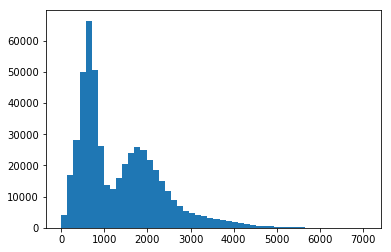

In [19]:
#hist for all w test stats
all_stats = []
for param, tests in full_results.items():
    if (np.max(tests[3][0]) < 10000 ):
        all_stats.append(tests[3][0])
flat_list = [item for sublist in all_stats for item in sublist]
plt.figure()
plt.hist(flat_list, bins=50)
plt.show()

[ 0.    0.56  0.33  0.38] 0.558308205148


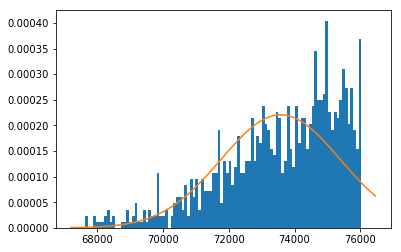

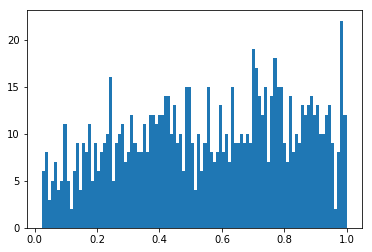

[ 0.     0.56   0.33   0.415] 0.362002896177


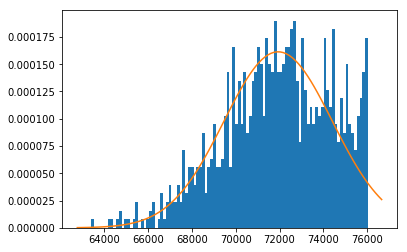

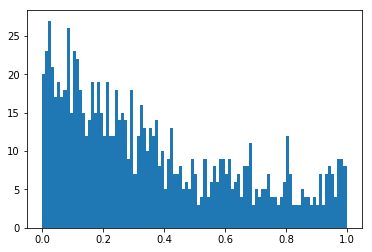

[ 0.    0.56  0.34  0.38] 0.597797183666


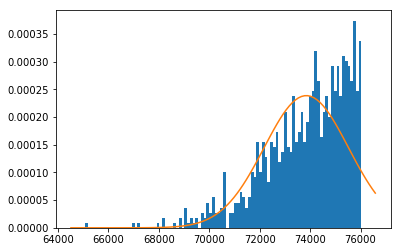

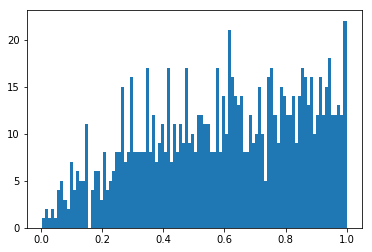

[ 0.    0.56  0.35  0.38] 0.501555870144


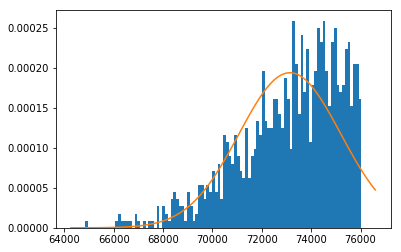

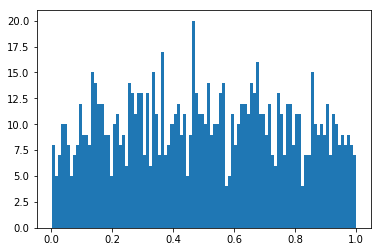

[ 0.    0.56  0.36  0.38] 0.387750645064


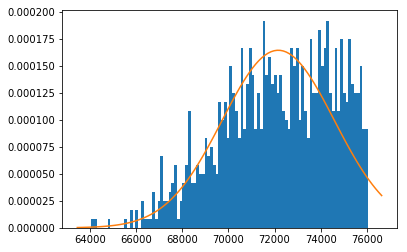

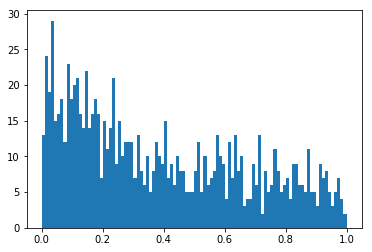

[ 0.     0.57   0.33   0.415] 0.512360548035


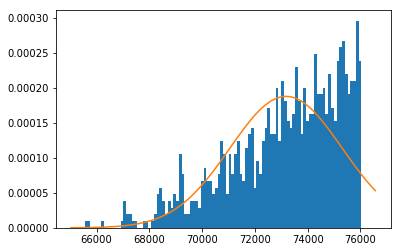

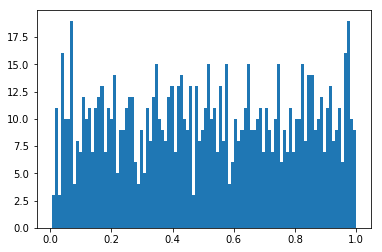

[ 0.    0.57  0.33  0.45] 0.435539302311


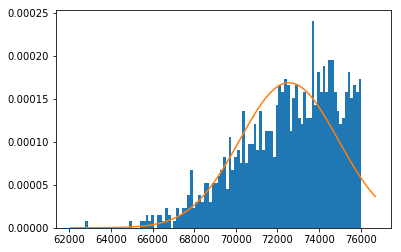

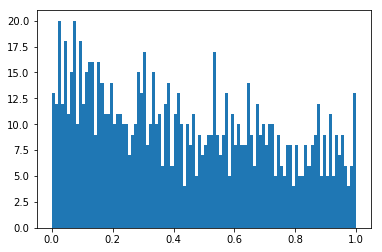

[ 0.     0.57   0.34   0.415] 0.581639772315


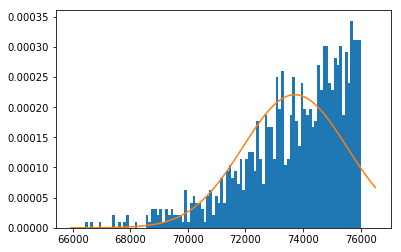

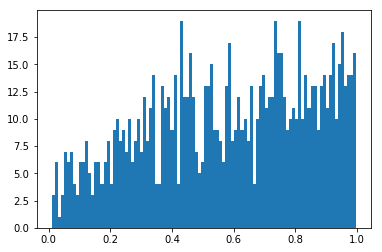

[ 0.    0.57  0.35  0.38] 0.356696262595


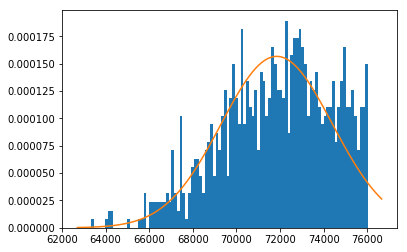

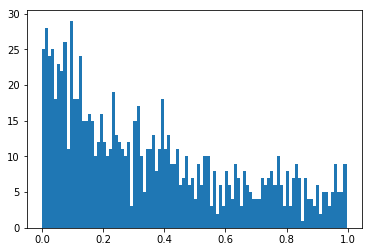

[ 0.     0.57   0.35   0.415] 0.51209924382


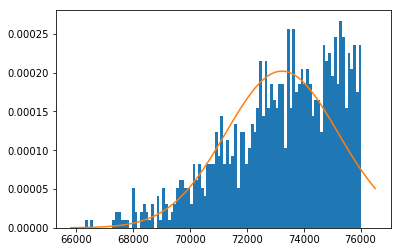

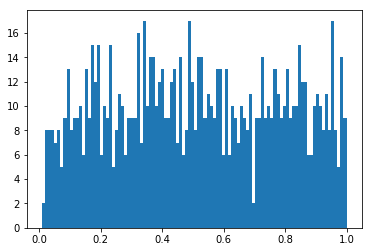

[ 0.    0.57  0.36  0.38] 0.498480588978


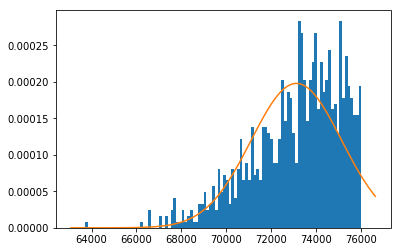

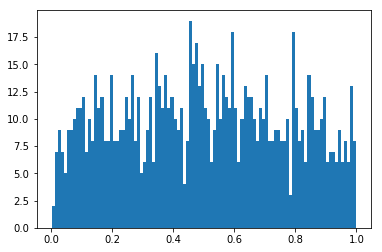

[ 0.     0.57   0.36   0.415] 0.406975617636


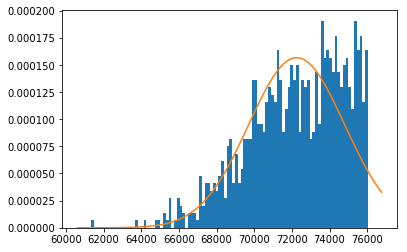

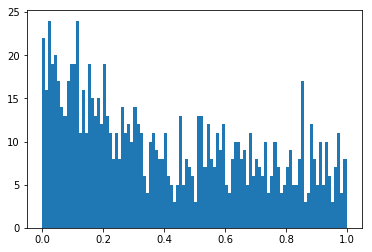

[ 0.    0.57  0.37  0.38] 0.565930249255


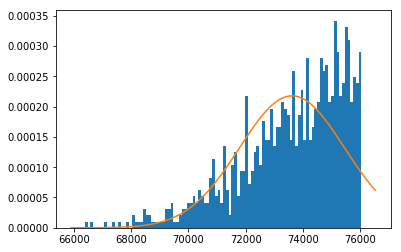

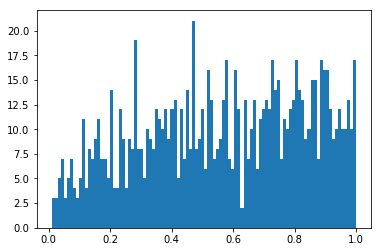

[ 0.    0.58  0.33  0.45] 0.473622795682


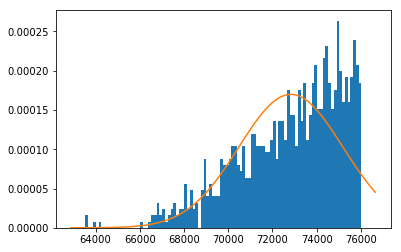

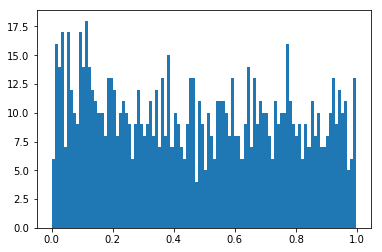

[ 0.     0.58   0.33   0.485] 0.48624953239


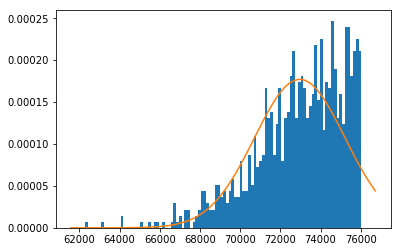

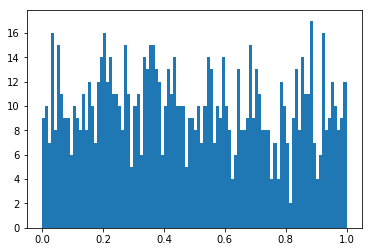

[ 0.    0.58  0.34  0.45] 0.571305764729


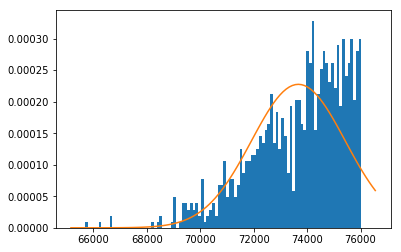

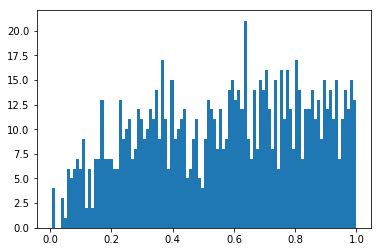

[ 0.     0.58   0.34   0.485] 0.359671428745


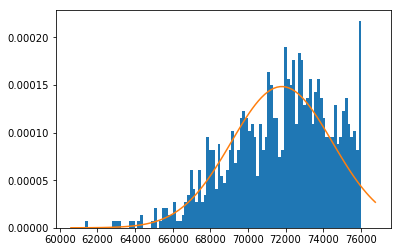

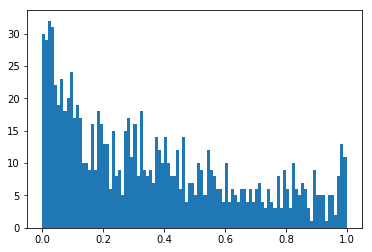

[ 0.     0.58   0.35   0.415] 0.358359798031


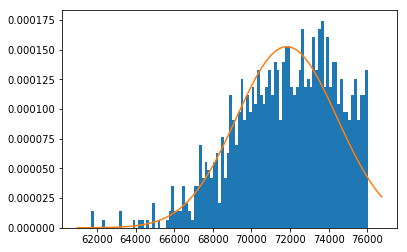

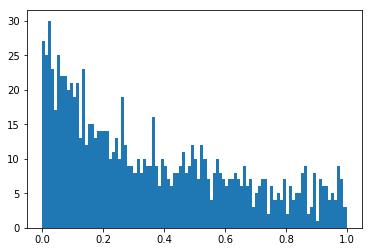

[ 0.    0.58  0.35  0.45] 0.536800148395


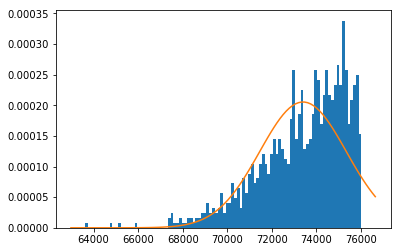

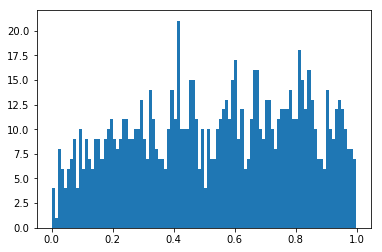

[ 0.     0.58   0.36   0.415] 0.479311693505


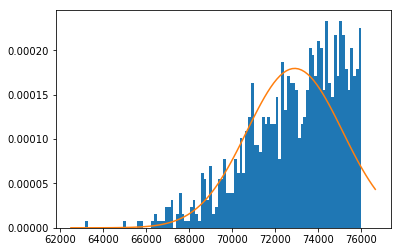

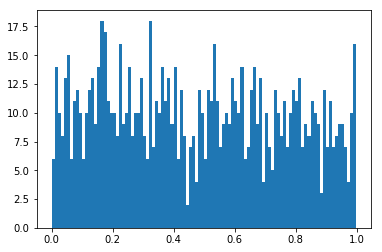

[ 0.    0.58  0.36  0.45] 0.428807058088


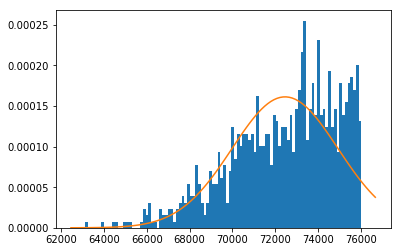

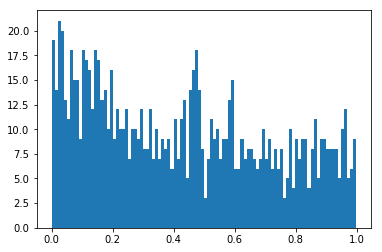

[ 0.     0.58   0.37   0.415] 0.562664387673


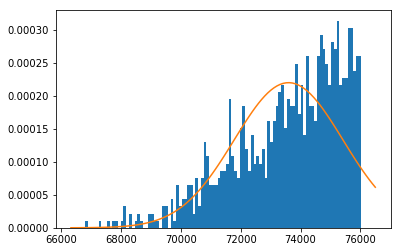

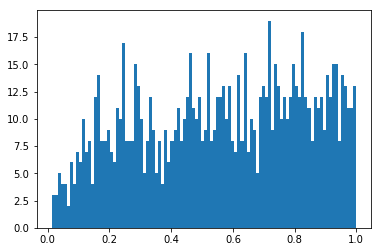

[ 0.    0.58  0.37  0.45] 0.305065557833


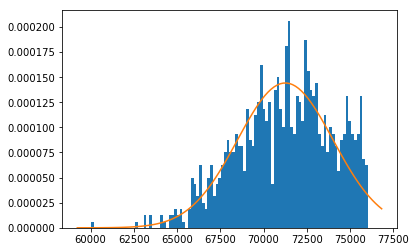

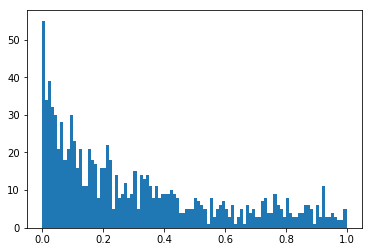

[ 0.     0.59   0.33   0.485] 0.430569041014


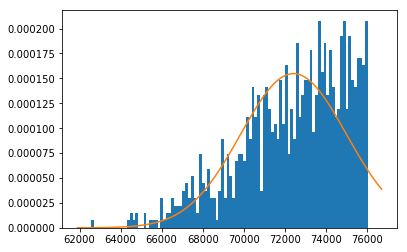

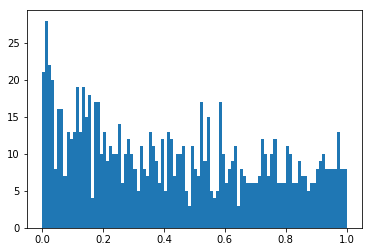

[ 0.    0.59  0.33  0.52] 0.507686343939


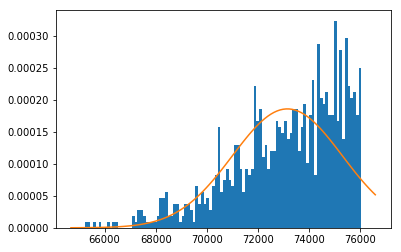

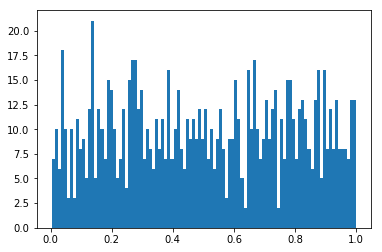

[ 0.     0.59   0.34   0.485] 0.539089864349


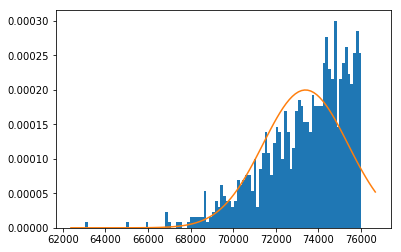

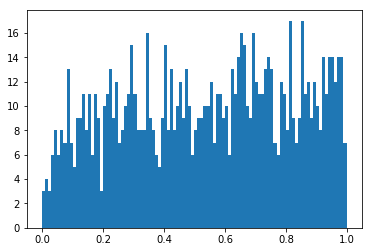

[ 0.    0.59  0.34  0.52] 0.379031623192


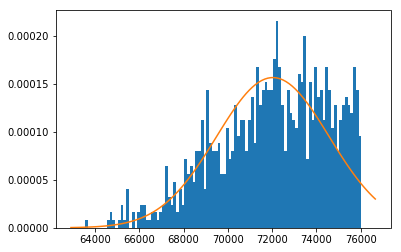

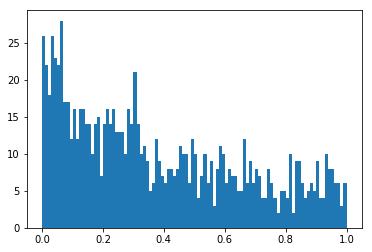

[ 0.    0.59  0.35  0.45] 0.356529377309


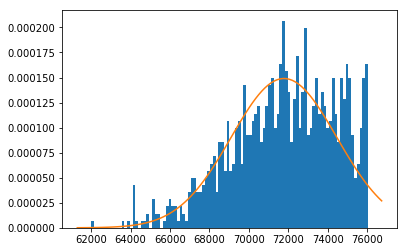

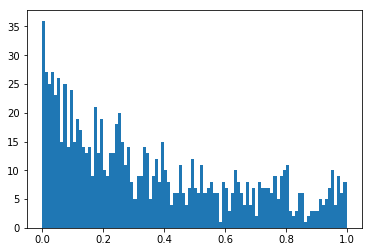

[ 0.     0.59   0.35   0.485] 0.544894381982


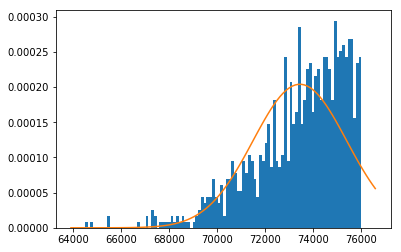

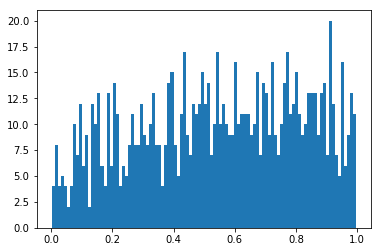

[ 0.    0.59  0.36  0.45] 0.501769440298


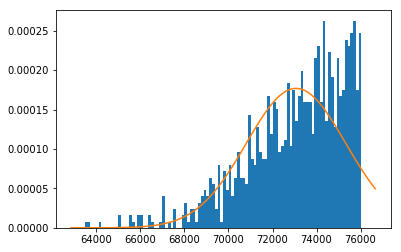

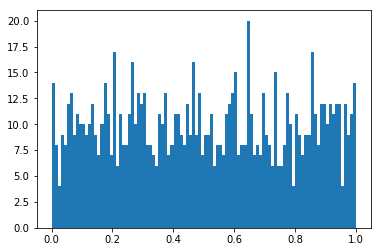

[ 0.     0.59   0.36   0.485] 0.436431285513


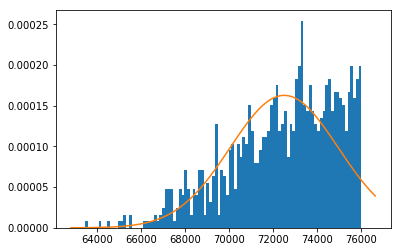

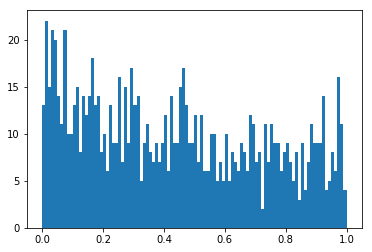

[ 0.    0.59  0.37  0.45] 0.55324032162


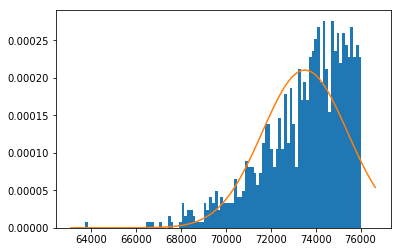

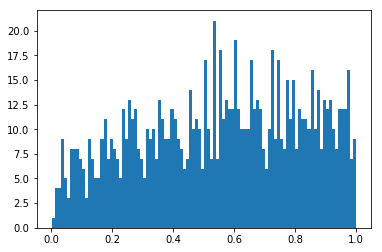

[ 0.     0.59   0.37   0.485] 0.313471983387


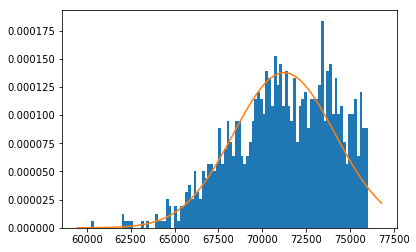

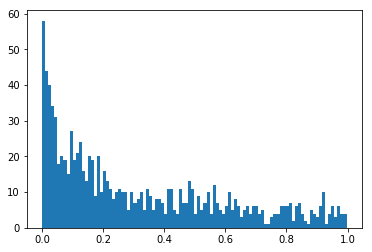

In [21]:
#print w stat and p value distributions based on restriction
for param, tests in full_results.items():
    if np.mean(tests[3][1])>.3: #looking at high mean p-values
        print(param, np.mean(tests[3][1]))
        plt.figure()
        plt.hist(tests[3][0], bins=100, normed=True)
        mu, std = norm.fit(tests[3][0])
        xmin, xmax = plt.xlim()
        x = np.linspace(xmin, xmax, 100)
        y = norm.pdf(x, mu, std)
        plt.plot(x, y)
        plt.figure()
        plt.hist(tests[3][1], bins=100)
        plt.show()

0.145747731397 9.06274866307e-05 [ 0.   0.6  0.1  2. ]
0.001 5.95856678396e-92 [  5.00000000e-04   6.00000000e-01   1.00000000e+00   1.00000000e-02]


/Users/rebeccachen/anaconda/lib/python3.6/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


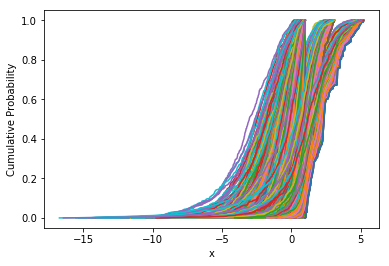

In [114]:
sort_y = np.sort(planets_etamb)
p = np.linspace(0, 1, len(planets_etamb))
data_CDF = lambda x: np.interp(x, sort_y, p)
plt.figure(1)
#find lowest peak of histogram for each test
lowest_ks = np.inf
lowest_mwu = np.inf
lowest_w = np.inf
stat_num = 0 #0-test stats 1-p-values
for params, arr in full_results.items():
    counts_ks, bins_ks= np.histogram(arr[1][stat_num], bins=100)
    mu_ks, std_ks = norm.fit(arr[1][stat_num])
#     counts_mwu, bins_mwu = np.histogram(arr[2][stat_num], bins=100)
#     mu_mwu, std_mwu = norm.fit(arr[2][stat_num])
    counts_w, bins_w = np.histogram(arr[3][stat_num], bins=100)
    mu_w, std_w = norm.fit(arr[3][stat_num])
    curr_samples = arr[0] #array of 1000 arrays of 550 values, 1000 sampled datasets
    plt.plot(np.sort(curr_samples[np.random.randint(0, 1000)]), p)
    if mu_ks != 0 and mu_ks < lowest_ks:
        lowest_ks = mu_ks
        lowest_ks_std = std_ks
        lowest_params_ks = params
        p_vals_ks = arr[1][1]
        stats_ks = arr[1][0]
        samples_ks = curr_samples
#     if mu_mwu != 0 and mu_mwu < lowest_mwu:
#         lowest_mwu = mu_mwu
#         lowest_mwu_std = std_mwu
#         lowest_params_mwu = params
#         p_vals_mwu = arr[2][1]
#         stats_mwu = arr[2][0]
#         samples_mwu = curr_samples
    if mu_w > 0.0 and mu_w < lowest_w: # looking at lowest mu that still passes a threshold
        lowest_w = mu_w
        lowest_w_std = std_w
        lowest_params_w = params
        p_vals_w = arr[3][1]
        stats_w = arr[3][0]
        samples_w = curr_samples
print(lowest_ks, np.mean(p_vals_ks), lowest_params_ks)
print(lowest_w, np.mean(p_vals_w), lowest_params_w)
# plt.plot(sort_y, p, label='data', lw='3.0', color="k")
plt.xlabel('x')
plt.ylabel('Cumulative Probability')
plt.legend(loc='upper left')
plt.show()

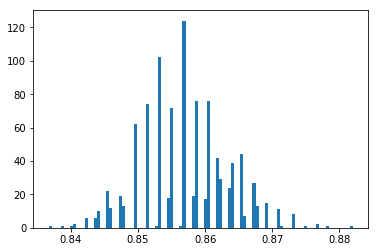

0.857049001815


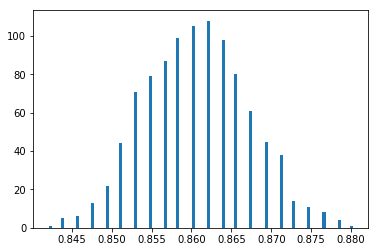

0.860635208711


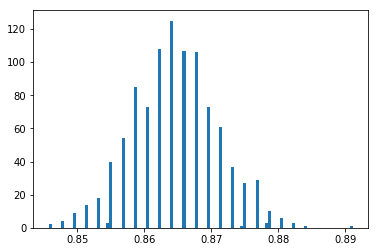

0.864388384755


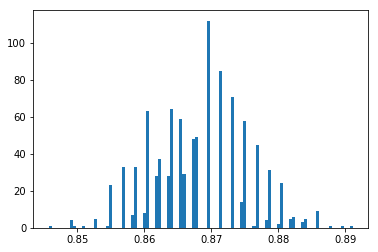

0.86799092559


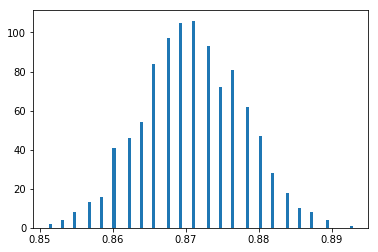

0.870903811252


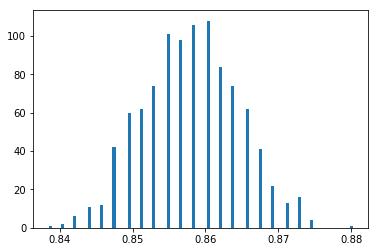

0.858023593466


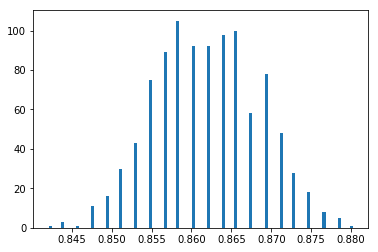

0.861929219601


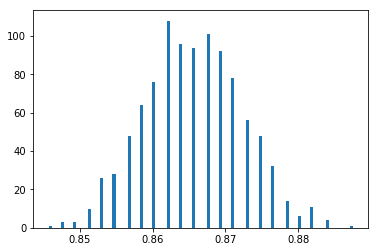

0.865586206897


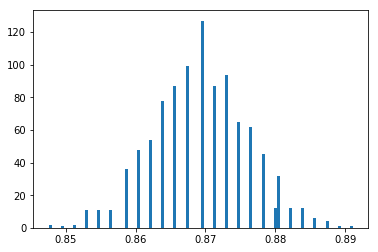

0.86933938294


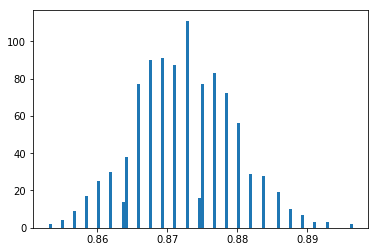

0.872297640653


In [25]:
#plot 10 of selected stat
test_num = 1 # 1-ks 2-mwu 3-wilcoxon
stat_num = 0 #0-test stats 1-p-values
count = 0
for params, arr in full_results.items():
    mu, std = norm.fit(arr[test_num][stat_num])
    if count<10:
        plt.figure()
        counts, bins, patches = plt.hist(arr[test_num][stat_num], bins=100)
        plt.show()
        plt.figure()
        print(mu)
        plt.show()
        count+=1

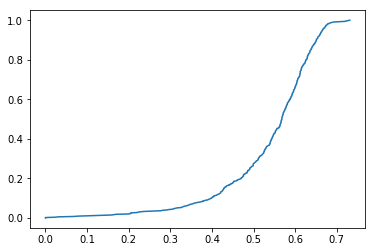

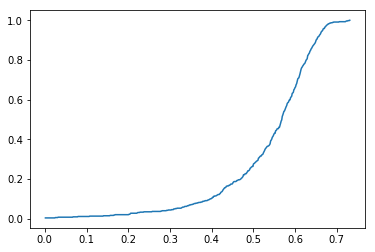

In [26]:
#two methods of plotting CDF (true dataset)
sort_y = np.sort(planets_etamb)
p = np.linspace(0, 1, len(planets_etamb))
data_CDF = lambda x: np.interp(x, sort_y, p)

plt.figure(1)
plt.plot(sort_y, p)
plt.show()

plt.figure(2)
num_bins = len(planets_etamb)
counts, bin_edges = np.histogram (planets_etamb, bins=num_bins, normed=True)
cdf = np.cumsum (counts)
plt.plot (bin_edges[1:], cdf/cdf[-1])
plt.show()